In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from qiskit import *

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
# np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [4]:
# !pip3 install qiskit.ibmq

In [5]:
token1 = '2b740fada862fb6d9683487f84455ff8fccb2caaa3988e4f406d321ef67ce0644eb679211a1b6a377ec5ee9b3839d34434255304ab535a9ed11ce60703f07446'
token2 = '08952555d263c29c9b015855d49bcbf0e7a3cb1354b5520743285bb48d19f0db420522be05c80dd1fb19179c42d798b238ae7b944568bb6e7e7284d9bfeb0209'

from qiskit import IBMQ
# IBMQ.save_account(token2)
# provider = IBMQ.enable_account(token1)
# dev = qml.device("default.qubit", wires=9)
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',provider=provider)
# IBMQ.get_provider(hub='ibm-q', group='open', project='main')
dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',
                 ibmqx_token=token1, hub='ibm-q', group='open', project='main')
print(dev.capabilities()['backend'])
# import pennylane as qml
# from pennylane_ionq import ops

# dev = qml.device("ionq.qpu", wires=9)

# Random circuit parameters

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(9):
        qml.RY(np.pi * phi[j], wires=j)
    
    # rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 9))
    # print("rand", rand_params)
    # Random quantum circuit
    RandomLayers(np.random.uniform(high=2 * np.pi, size=(n_layers, 9)), wires=list(range(9)), seed=None)
    
    # Measurement producing 9 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(9)]

AttributeError: can't set attribute

In [ ]:
def quanv(image,filters=9):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((26, 26, filters))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(1, 27, 1):
        for k in range(1, 27, 1):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = []
            for i in range(filters):
                q_result = circuit(
                    [
                        image[j - 1, k - 1, 0],
                        image[j - 1, k, 0],
                        image[j - 1, k + 1, 0],
                        image[j, k - 1, 0],
                        image[j, k, 0],
                        image[j, k + 1, 0],
                        image[j + 1, k - 1, 0],
                        image[j + 1, k, 0],
                        image[j + 1, k + 1, 0]
                    ]
                )
                # print(q_result)
            q_results.append(sum(q_result))
            # print(q_results,"hi")
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(filters):
                out[j - 1, k - 1, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images_f1_c9.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images_f1_c9.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images_f1_c9.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images_f1_c9.npy")

Quantum pre-processing of train images:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/util.py:101: DeprecationWarning: Use of `backend_options` is deprecated and will be removed in a future release.You can now pass backend options as key-value pairs to the run() method. For example: backend.run(circs, shots=2048).
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqbackend.py:810: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  return super().run(circuits, job_name=job_name, job_share_level=job_share_level,


SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)

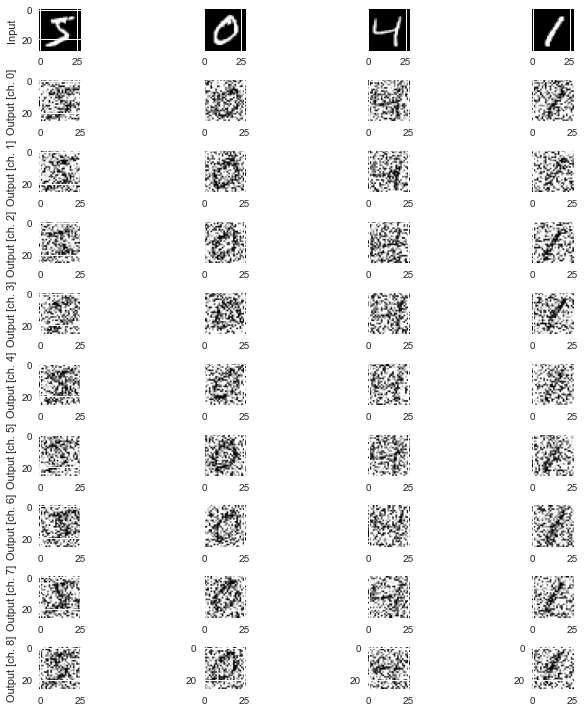

In [18]:
n_samples = 4
n_channels = 9
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [19]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=50,kernel_size=(5,5),activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [20]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.6855 - accuracy: 0.0800 - val_loss: 2.2814 - val_accuracy: 0.2333
Epoch 2/30
13/13 - 0s - loss: 2.2624 - accuracy: 0.1800 - val_loss: 2.2615 - val_accuracy: 0.2667
Epoch 3/30
13/13 - 0s - loss: 2.1351 - accuracy: 0.1800 - val_loss: 2.1811 - val_accuracy: 0.2667
Epoch 4/30
13/13 - 0s - loss: 1.9296 - accuracy: 0.3400 - val_loss: 2.0279 - val_accuracy: 0.4000
Epoch 5/30
13/13 - 0s - loss: 1.4940 - accuracy: 0.6200 - val_loss: 1.7861 - val_accuracy: 0.4000
Epoch 6/30
13/13 - 0s - loss: 1.0634 - accuracy: 0.7400 - val_loss: 1.2847 - val_accuracy: 0.6333
Epoch 7/30
13/13 - 0s - loss: 0.4327 - accuracy: 0.9000 - val_loss: 0.9241 - val_accuracy: 0.7333
Epoch 8/30
13/13 - 0s - loss: 0.1675 - accuracy: 1.0000 - val_loss: 1.0335 - val_accuracy: 0.6667
Epoch 9/30
13/13 - 0s - loss: 0.1081 - accuracy: 0.9800 - val_loss: 1.0861 - val_accuracy: 0.6667
Epoch 10/30
13/13 - 0s - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.9634 - val_accuracy: 0.7667
Epoch 11/30
13/13 -

In [21]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3459 - accuracy: 0.0800 - val_loss: 2.2259 - val_accuracy: 0.4333
Epoch 2/30
13/13 - 0s - loss: 2.1432 - accuracy: 0.3200 - val_loss: 1.8568 - val_accuracy: 0.5333
Epoch 3/30
13/13 - 0s - loss: 1.5994 - accuracy: 0.5200 - val_loss: 1.3608 - val_accuracy: 0.5667
Epoch 4/30
13/13 - 0s - loss: 0.8348 - accuracy: 0.7200 - val_loss: 1.0210 - val_accuracy: 0.6667
Epoch 5/30
13/13 - 0s - loss: 0.5335 - accuracy: 0.7800 - val_loss: 0.8773 - val_accuracy: 0.7000
Epoch 6/30
13/13 - 0s - loss: 0.2980 - accuracy: 0.9200 - val_loss: 0.8824 - val_accuracy: 0.8000
Epoch 7/30
13/13 - 0s - loss: 0.1387 - accuracy: 0.9600 - val_loss: 0.7904 - val_accuracy: 0.8000
Epoch 8/30
13/13 - 0s - loss: 0.0568 - accuracy: 1.0000 - val_loss: 0.6582 - val_accuracy: 0.8333
Epoch 9/30
13/13 - 0s - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.9885 - val_accuracy: 0.7333
Epoch 10/30
13/13 - 0s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.9936 - val_accuracy: 0.8000
Epoch 11/30
13/13 -

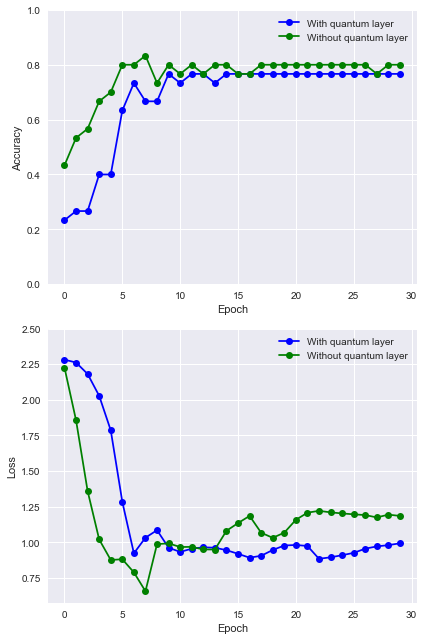

In [22]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()